In [1]:
%matplotlib notebook

import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from classes.Settings import Settings
from helpers.geometry_helpers import make_avg_fragment_if_not_exists
from helpers.helpers import read_results_alignment
from helpers.plot_functions import plot_density, plot_fragment_colored, plot_vdw_spheres
from helpers.density_helpers import calculate_no_bins, add_boundaries_per_bin

from sklearn.cluster import KMeans

from tqdm import tqdm
import time
import math
import copy

In [2]:
resolutions = []
resolutions0 = np.arange(0.02, 0.1, 0.01)
resolutions.extend(resolutions0)

resolutions1 = np.arange(0.1, 1.1, 0.1)
resolutions.extend(resolutions1)

## Volume central group

In [3]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

print(avg_fragment)
vec1 = np.array([avg_fragment[avg_fragment.atom_label == "O2"].atom_x, avg_fragment[avg_fragment.atom_label == "O2"].atom_y, avg_fragment[avg_fragment.atom_label == "O2"].atom_z])
vec2 = np.array([avg_fragment[avg_fragment.atom_label == "H3"].atom_x, avg_fragment[avg_fragment.atom_label == "H3"].atom_y, avg_fragment[avg_fragment.atom_label == "H3"].atom_z])
vec2 = vec1 - vec2

dist1 = np.linalg.norm(vec1)
dist2 = np.linalg.norm(vec2)

angle = np.arccos(np.dot(vec1.T, vec2) / (dist1 * dist2))
print(dist1, dist2, np.rad2deg(angle[0])[0])

  atom_label atom_symbol    atom_x        atom_y        atom_z  vdw_radius
0         H1           H  0.000000  0.000000e+00  0.000000e+00        1.09
1         H3           H  1.131047  8.129646e-01 -5.680242e-17        1.09
2         O2           O  0.866111 -1.051792e-16 -2.394653e-17        1.52
0.8661108586162624 0.8550454989215917 108.0502384306134


In [4]:
from numba import jit
from numba import prange

@jit(nopython=True, parallel=True)
def calc_distances(in_vdw_volume, bin_coordinates, avg_f_p, indices, extra):
    
    for i in prange(len(indices)):
        idx = indices[i]

        bin_point = bin_coordinates[idx[0]]
        distance = np.sum((bin_point - avg_f_p[:3])**2)**0.5

        if distance < avg_f_p[3] + extra:
            in_vdw_volume[idx] = 1

    return in_vdw_volume


def rough_estimation(avg_fragment, settings):
    extra = 0.5 + 1.7
    
    avg_fragment['minx'] = avg_fragment['atom_x'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['miny'] = avg_fragment['atom_y'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['minz'] = avg_fragment['atom_z'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['maxx'] = avg_fragment['atom_x'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxy'] = avg_fragment['atom_y'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxz'] = avg_fragment['atom_z'] + avg_fragment['vdw_radius'] + extra
    
    minx, miny, minz = avg_fragment['minx'].min(), avg_fragment['miny'].min(), avg_fragment['minz'].min()
    maxx, maxy, maxz = avg_fragment['maxx'].max(), avg_fragment['maxy'].max(), avg_fragment['maxz'].max()
    
    print('Rough estimation of the volume:', abs(maxx-minx) * abs(maxy-miny) * abs(maxz-minz))

def count_bins_in_vdw(avg_fragment, settings):
    # TODO: dit runnen
    extra = 0.5 + 1.09
    
    avg_fragment['minx'] = avg_fragment['atom_x'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['miny'] = avg_fragment['atom_y'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['minz'] = avg_fragment['atom_z'] - avg_fragment['vdw_radius'] - extra
    avg_fragment['maxx'] = avg_fragment['atom_x'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxy'] = avg_fragment['atom_y'] + avg_fragment['vdw_radius'] + extra
    avg_fragment['maxz'] = avg_fragment['atom_z'] + avg_fragment['vdw_radius'] + extra
    
    minx, miny, minz = avg_fragment['minx'].min(), avg_fragment['miny'].min(), avg_fragment['minz'].min()
    maxx, maxy, maxz = avg_fragment['maxx'].max(), avg_fragment['maxy'].max(), avg_fragment['maxz'].max()
      
    no_bins_x, minx, maxx = calculate_no_bins(minx, maxx, settings.resolution)
    no_bins_y, miny, maxy = calculate_no_bins(miny, maxy, settings.resolution)
    no_bins_z, minz, maxz = calculate_no_bins(minz, maxz, settings.resolution)
        
    amount_bins = no_bins_x * no_bins_y * no_bins_z
    indices = [i for i in range(0, amount_bins)]

    bins = [np.linspace(minx, maxx, num=no_bins_x, endpoint=False),
            np.linspace(miny, maxy, num=no_bins_y, endpoint=False),
            np.linspace(minz, maxz, num=no_bins_z, endpoint=False)] 

    df = add_boundaries_per_bin(bins, indices, settings)
    
    df['x_center'] = df.xstart + 0.5 * settings.resolution
    df['y_center'] = df.ystart + 0.5 * settings.resolution
    df['z_center'] = df.zstart + 0.5 * settings.resolution
    
    part_density = df[(df.x_center < maxx) & (df.x_center > minx) &
                      (df.y_center < maxy) & (df.y_center > miny) &
                      (df.z_center < maxz) & (df.z_center > minz)] 
    
    bin_coordinates = np.transpose(np.array([part_density.x_center, part_density.y_center, part_density.z_center]))

    time.sleep(0.5)
    
    in_vdw_vol = np.zeros(len(df))
    
    for i, atom in avg_fragment.iterrows():
        indices = np.transpose(np.where(in_vdw_vol == 0))
        
        fragment_point = np.array([atom.atom_x, atom.atom_y, atom.atom_z, atom.vdw_radius])

        in_vdw_vol = calc_distances(in_vdw_vol, bin_coordinates, fragment_point, indices, extra)
                
    total = np.sum(in_vdw_vol)
    df['in_vdw_volume'] = in_vdw_vol

    return df, total


In [5]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")
settings.set_resolution(0.1)

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

print(avg_fragment)

volume_df, amount_bins = count_bins_in_vdw(avg_fragment, settings)

print('Bins:', amount_bins)
print('Volume:', amount_bins * settings.resolution**3)

  atom_label atom_symbol    atom_x        atom_y        atom_z  vdw_radius
0         H1           H  0.000000  0.000000e+00  0.000000e+00        1.09
1         H3           H  1.131047  8.129646e-01 -5.680242e-17        1.09
2         O2           O  0.866111 -1.051792e-16 -2.394653e-17        1.52
Bins: 143615.0
Volume: 143.61500000000004


,xstart,ystart,zstart,F,x_center,y_center,z_center,in_vdw_volume
0,-2.700000,-3.100000,-3.100000,0.0,-2.650000,-3.050000,-3.050000,0.0
1,-2.700000,-3.100000,-3.001587,0.0,-2.650000,-3.050000,-2.951587,0.0
2,-2.700000,-3.100000,-2.903175,0.0,-2.650000,-3.050000,-2.853175,0.0
3,-2.700000,-3.100000,-2.804762,0.0,-2.650000,-3.050000,-2.754762,0.0
4,-2.700000,-3.100000,-2.706349,0.0,-2.650000,-3.050000,-2.656349,0.0
...,...,...,...,...,...,...,...,...
287023,3.901471,3.401493,2.607937,0.0,3.951471,3.451493,2.657937,0.0
287024,3.901471,3.401493,2.706349,0.0,3.951471,3.451493,2.756349,0.0
287025,3.901471,3.401493,2.804762,0.0,3.951471,3.451493,2.854762,0.0
287026,3.901471,3.401493,2.903175,0.0,3.951471,3.451493,2.953175,0.0


<IPython.core.display.Javascript object>


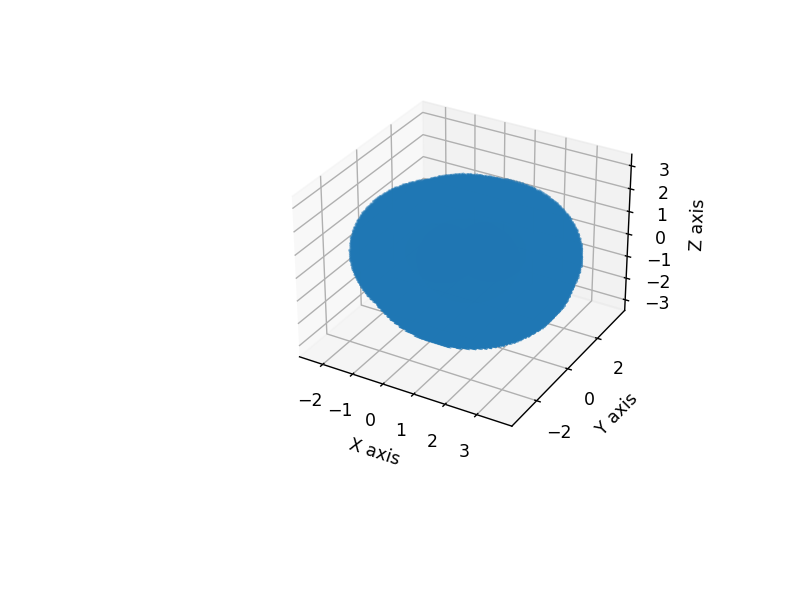

Text(0.5, 0, 'Z axis')

In [6]:
display(volume_df)

plot_bins = volume_df[volume_df.in_vdw_volume > 0]

fig = plt.figure()
ax: Axes3D = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0.25, bottom=0.25)

ax.margins(x=0)
ax = plot_fragment_colored(ax, avg_fragment)

# Create vdw spheres around central group atoms
ax, spheres1 = plot_vdw_spheres(avg_fragment, ax, 'red')

ax.scatter(plot_bins.x_center, plot_bins.y_center, plot_bins.z_center, s=0.2)

ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

# Here come the long calculations

In [ ]:
settings = Settings(".\\results\\H2O\\H2O_CF_vdw.5\\H2O_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

H2O_bins = []
H2O_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))

    starttime = time.time()
    settings.set_resolution(round(resolution,2))

    _, total = count_bins_in_vdw(avg_fragment, settings)
    
    H2O_bins.append(total)
    H2O_comp_time.append(time.time() - starttime)

In [ ]:
settings = Settings(".\\results\\NO3\\NO3_CF_vdw.5\\NO3_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

NO3_bins = []
NO3_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    starttime = time.time()

    settings.set_resolution(round(resolution,2))
    rough_estimation(avg_fragment, settings)
    _, total = count_bins_in_vdw(avg_fragment, settings)
    NO3_bins.append(total)

    NO3_comp_time.append(time.time() - starttime)


In [ ]:
settings = Settings(".\\results\\RC6H5\\RC6H5_CF_vdw.5\RC6H5_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

RC6H5_bins = []
RC6H5_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    
    starttime = time.time()
    settings.set_resolution(round(resolution,2))
    rough_estimation(avg_fragment, settings)
    
    _, total = count_bins_in_vdw(avg_fragment, settings)
    RC6H5_bins.append(total)

    RC6H5_comp_time.append(time.time() - starttime)

In [ ]:
settings = Settings(".\\results\\RC6F5\\RC6F5_CF_vdw.5\RC6F5_CF_vdw.5_aligned.csv")
settings.set_atom_to_count("F")

df = read_results_alignment(settings.get_aligned_csv_filename())
avg_fragment = make_avg_fragment_if_not_exists(settings, df)

RC6F5_bins = []
RC6F5_comp_time = []

for resolution in resolutions:
    print(round(resolution,2))
    starttime = time.time()
    settings.set_resolution(round(resolution,2))
    rough_estimation(avg_fragment, settings)
    
    _, total = count_bins_in_vdw(avg_fragment, settings)
    RC6F5_bins.append(total)

    RC6F5_comp_time.append(time.time() - starttime)

# Save results

In [ ]:
# import csv

# print(len(H2O_bins), len(NO3_bins), len(RC6H5_bins), len(RC6F5_bins), len(RC6H5_comp_time), len(RC6F5_comp_time))
# # RC6H5_bins.append(np.nan)
# # RC6F5_bins.append(np.nan)
# # RC6F5_comp_time.append(np.nan)
# # RC6H5_comp_time.append(np.nan)
# print(resolutions)

# # save
# with open("test.csv", "a", newline='') as resultsFile:
#     writer = csv.writer(resultsFile, delimiter=",")
    
#     for i in range(len(resolutions)):
#         print(round(resolutions[-i-1], 2), H2O_bins[i], NO3_bins[i], RC6H5_bins[i], RC6F5_bins[i])
    
#         writer.writerow([round(resolutions[-i -1], 2), H2O_bins[i], H2O_comp_time[i], NO3_bins[i], NO3_comp_time[i], 
#                          RC6H5_bins[i], RC6H5_comp_time[i], RC6F5_bins[i], RC6F5_comp_time[i]])

## Resultaten plotten

In [ ]:
# reference values
real_water = 16.85
real_nitrate = 40.0872
real_aryl = 89.0991
real_pentafluoroaryl = 122.2819

real_water_max = 232.971
real_nitrate_max = 365.532
real_aryl_max = 577.290
real_pentafluoroaryl_max = 728.153

In [ ]:
volumes = pd.read_csv('results/volumes.csv', header=None)
volumes.columns = ['resolution', 'bins_h2o', 'time_h2o', 'bins_no3', 'time_no3', 'bins_rc6h5', 
                               'time_rc6h5', 'bins_rc6f5', 'time_rc6f5']

volumes['h2o_volume'] = volumes.bins_h2o * volumes.resolution**3
volumes['h2o_perc'] = abs((real_water - volumes.h2o_volume) / volumes.h2o_volume * 100)

volumes['no3_volume'] = volumes.bins_no3 * volumes.resolution**3
volumes['no3_perc'] = abs((real_nitrate - volumes.no3_volume) / volumes.no3_volume * 100)

volumes['rc6h5_volume'] = volumes.bins_rc6h5 * volumes.resolution**3
volumes['rc6h5_perc'] = abs((real_aryl - volumes.rc6h5_volume) / volumes.rc6h5_volume * 100)

volumes['rc6f5_volume'] = volumes.bins_rc6f5 * volumes.resolution**3
volumes['rc6f5_perc'] = abs((real_pentafluoroaryl - volumes.rc6f5_volume) / volumes.rc6f5_volume * 100)

display(volumes)

In [ ]:
def read_csv_max(filename):
    volumes_max = pd.read_csv(filename, header=None)
    volumes_max.columns = ['resolution', 'bins_h2o', 'time_h2o', 'bins_no3', 'time_no3', 'bins_rc6h5', 
                                   'time_rc6h5', 'bins_rc6f5', 'time_rc6f5']

    volumes_max['h2o_volume'] = volumes_max.bins_h2o * volumes_max.resolution**3
    volumes_max['h2o_perc'] = abs((real_water_max - volumes_max.h2o_volume) / volumes_max.h2o_volume * 100)

    volumes_max['no3_volume'] = volumes_max.bins_no3 * volumes_max.resolution**3
    volumes_max['no3_perc'] = abs((real_nitrate_max - volumes_max.no3_volume) / volumes_max.no3_volume * 100)

    volumes_max['rc6h5_volume'] = volumes_max.bins_rc6h5 * volumes_max.resolution**3
    volumes_max['rc6h5_perc'] = abs((real_aryl_max - volumes_max.rc6h5_volume) / volumes_max.rc6h5_volume * 100)

    volumes_max['rc6f5_volume'] = volumes_max.bins_rc6f5 * volumes_max.resolution**3
    volumes_max['rc6f5_perc'] = abs((real_pentafluoroaryl_max - volumes_max.rc6f5_volume) / volumes_max.rc6f5_volume * 100)

    return volumes_max

volumes_max = read_csv_max('results/volumes_max.csv')
volumes_max_jit = read_csv_max('results/volumes_max_jit.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
plt.title("Volume of $H_2O$ as central group, with different resolutions\n Contact group: CF")

ax.scatter(resolutions, volumes.h2o_volume, label="$H_2O$", color='green')
ax.plot(resolutions, volumes.h2o_volume, color='green')
ax.scatter(resolutions, volumes.no3_volume, label="$NO_3^-$", color='blue')
ax.plot(resolutions, volumes.no3_volume, color='blue')
ax.scatter(resolutions, volumes.rc6h5_volume, label="$RC_6H_5$", color='red')
ax.plot(resolutions, volumes.rc6h5_volume, color='red')
ax.scatter(resolutions, volumes.rc6f5_volume, label="$RC_6F_5$", color='orchid')
ax.plot(resolutions, volumes.rc6f5_volume, color='orchid')

ax.scatter(volumes_max.resolution, volumes_max.h2o_volume, label="$H_2O + 0.5 + vdw 1.7$", color='darkgreen')
ax.plot(volumes_max.resolution, volumes_max.h2o_volume, color='darkgreen')
ax.scatter(volumes_max.resolution, volumes_max.no3_volume, label="$NO_3^-  + 0.5 + vdw 1.7$", color='darkblue')
ax.plot(volumes_max.resolution, volumes_max.no3_volume, color='darkblue')
ax.scatter(volumes_max.resolution, volumes_max.rc6h5_volume, label="$RC_6H_5  + 0.5 + vdw 1.7$", color='darkred')
ax.plot(volumes_max.resolution, volumes_max.rc6h5_volume, color='darkred')
ax.scatter(volumes_max.resolution, volumes_max.rc6f5_volume, label="$RC_6F_5  + 0.5 + vdw 1.7$", color='darkorchid')
ax.plot(volumes_max.resolution, volumes_max.rc6f5_volume, color='darkorchid')

ax.set_ylabel(r'volume ($\AA^3$)')
ax.set_xlabel("resolution")
ax.legend(loc='upper right')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
plt.suptitle("Volume central groups, contact group: CF")

# plot absolute difference
ax1.scatter(resolutions, volumes.h2o_perc, label="$H_2O$", color='green')
ax1.plot(resolutions, volumes.h2o_perc, color='green')
ax1.scatter(resolutions, volumes.no3_perc, label="$NO_3^-$", color='blue')
ax1.plot(resolutions, volumes.no3_perc, color='blue')
ax1.scatter(resolutions, volumes.rc6h5_perc, label="$RC_6H_5$", color='red')
ax1.plot(resolutions, volumes.rc6h5_perc, color='red')
ax1.scatter(resolutions, volumes.rc6f5_perc, label="$RC_6F_5$", color='orchid')
ax1.plot(resolutions, volumes.rc6f5_perc, color='orchid')

ax1.set_ylim(0, 10)
ax1.set_xlim(0, 0.1)

# plot time
# ax2.set_yscale('log')
ax2.plot(resolutions, volumes.time_h2o, color='green', label="$H_2O$ time")
ax2.scatter(resolutions, volumes.time_h2o, color='green')
ax2.plot(resolutions, volumes.time_no3, color='blue', label='$NO_3^-$ time')
ax2.scatter(resolutions, volumes.time_no3, color='blue')
ax2.scatter(resolutions, volumes.time_rc6h5, color='red')
ax2.plot(resolutions, volumes.time_rc6h5, color='red', label="$RC_6H_5$ time")
ax2.scatter(resolutions, volumes.time_rc6f5, color='orchid')
ax2.plot(resolutions, volumes.time_rc6f5, color='orchid', label="$RC_6F_5$ time")
ax2.set_xlim(0, 0.1)
ax2.set_ylim(-100, 3500)
# ax2.vlines(0.03, 0, 100000, colors='black')

ax1.hlines(3, 0, 1, colors='black')
ax1.hlines(5, 0, 1, colors='black')

ax1.set_title('Percentage error')
ax2.set_title('Computational time')
ax2.set_ylabel('Computational time (seconds)')
ax2.set_xlabel('resolution')

ax1.set_ylabel(r'Percentage')
ax1.set_xlabel("resolution")

ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig('volumes.eps', format='eps')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
plt.suptitle("Volume central groups, contact group: CF")

# plot absolute difference
ax1.scatter(volumes_max.resolution, volumes_max.h2o_perc, label="$H_2O + 0.5 + vdw1.7$", color='green')
ax1.plot(volumes_max.resolution, volumes_max.h2o_perc, color='green')
ax1.scatter(volumes_max.resolution, volumes_max.no3_perc, label="$NO_3^- + 0.5 + vdw1.7$", color='blue')
ax1.plot(volumes_max.resolution, volumes_max.no3_perc, color='blue')
ax1.scatter(volumes_max.resolution, volumes_max.rc6h5_perc, label="$RC_6H_5 + 0.5 + vdw1.7$", color='red')
ax1.plot(volumes_max.resolution, volumes_max.rc6h5_perc, color='red')
ax1.scatter(volumes_max.resolution, volumes_max.rc6f5_perc, label="$RC_6F_5 + 0.5 + vdw1.7$", color='orchid')
ax1.plot(volumes_max.resolution, volumes_max.rc6f5_perc, color='orchid')

ax1.set_ylim(0, 10)
ax1.set_xlim(0, 0.1)

# plot time
# ax2.set_yscale('log')
ax2.plot(volumes_max.resolution, volumes_max.time_h2o, color='green', label="$H_2O$ time")
ax2.scatter(volumes_max.resolution, volumes_max.time_h2o, color='green')
ax2.plot(volumes_max.resolution, volumes_max.time_no3, color='blue', label='$NO_3^-$ time')
ax2.scatter(volumes_max.resolution, volumes_max.time_no3, color='blue')
ax2.scatter(volumes_max.resolution, volumes_max.time_rc6h5, color='red')
ax2.plot(volumes_max.resolution, volumes_max.time_rc6h5, color='red', label="$RC_6H_5$ time")
ax2.scatter(volumes_max.resolution, volumes_max.time_rc6f5, color='orchid')
ax2.plot(volumes_max.resolution, volumes_max.time_rc6f5, color='orchid', label="$RC_6F_5$ time")

# ax2.plot(volumes_max.resolution, H2O_comp_time)

ax2.set_xlim(0, 0.1)
ax2.set_ylim(-100, 3500)
ax2.vlines(0.04, -1000, 100000, colors='black')

ax1.hlines(3, 0, 1, colors='black')
# ax1.hlines(3, 0, 1, colors='black')

ax1.set_title('Percentage error')
ax2.set_title('Computational time')
ax2.set_ylabel('Computational time (seconds)')
ax2.set_xlabel('resolution')

ax1.set_ylabel(r'Percentage')
ax1.set_xlabel("resolution")

ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig('max_volumes.eps', format='eps')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,5))
plt.suptitle("Volume central groups, contact group: CF")

# plot absolute difference
ax1.scatter(volumes_max_jit.resolution, volumes_max_jit.h2o_perc, label="$H_2O + 0.5 + vdw1.7$", color='green')
ax1.plot(volumes_max_jit.resolution, volumes_max_jit.h2o_perc, color='green')
ax1.scatter(volumes_max_jit.resolution, volumes_max_jit.no3_perc, label="$NO_3^- + 0.5 + vdw1.7$", color='blue')
ax1.plot(volumes_max_jit.resolution, volumes_max_jit.no3_perc, color='blue')
ax1.scatter(volumes_max_jit.resolution, volumes_max_jit.rc6h5_perc, label="$RC_6H_5 + 0.5 + vdw1.7$", color='red')
ax1.plot(volumes_max_jit.resolution, volumes_max_jit.rc6h5_perc, color='red')
ax1.scatter(volumes_max_jit.resolution, volumes_max_jit.rc6f5_perc, label="$RC_6F_5 + 0.5 + vdw1.7$", color='orchid')
ax1.plot(volumes_max_jit.resolution, volumes_max_jit.rc6f5_perc, color='orchid')

ax1.set_ylim(0, 10)
ax1.set_xlim(0, 0.1)


ax2.plot(volumes_max_jit.resolution, volumes_max_jit.time_h2o, color='green', label="$H_2O$ time")
ax2.scatter(volumes_max_jit.resolution, volumes_max_jit.time_h2o, color='green')
ax2.plot(volumes_max_jit.resolution, volumes_max_jit.time_no3, color='blue', label='$NO_3^-$ time')
ax2.scatter(volumes_max_jit.resolution, volumes_max_jit.time_no3, color='blue')
ax2.scatter(volumes_max_jit.resolution, volumes_max_jit.time_rc6h5, color='red')
ax2.plot(volumes_max_jit.resolution, volumes_max_jit.time_rc6h5, color='red', label="$RC_6H_5$ time")
ax2.scatter(volumes_max_jit.resolution, volumes_max_jit.time_rc6f5, color='orchid')
ax2.plot(volumes_max_jit.resolution, volumes_max_jit.time_rc6f5, color='orchid', label="$RC_6F_5$ time")

# ax2.plot(volumes_max.resolution, H2O_comp_time)

ax2.set_xlim(0, 0.1)
# ax2.set_ylim(-100, 350)
# ax2.vlines(0.04, -1000, 100000, colors='black')

ax1.hlines(3, 0, 1, colors='black')
# ax1.hlines(3, 0, 1, colors='black')

ax1.set_title('Percentage error')
ax2.set_title('Computational time using jit')
ax2.set_ylabel('Computational time (seconds)')
ax2.set_xlabel('resolution')

ax1.set_ylabel(r'Percentage')
ax1.set_xlabel("resolution")

ax1.legend()
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.savefig('max_volumes_jit.eps', format='eps')

In [ ]:
display(volumes_max[volumes_max.resolution < 0.05])

volumes = volumes.reindex(index=volumes.index[::-1])
volumes = volumes.reset_index()

In [ ]:
H2O_diff = real_water_max - real_water
NO3_diff = real_nitrate_max - real_nitrate
RC6H5_diff = real_aryl_max - real_aryl
RC6F5_diff = real_pentafluoroaryl_max - real_pentafluoroaryl

volumes_max['h2o_diff'] = (volumes_max.h2o_volume - volumes.h2o_volume)
volumes_max['h2o_perc_diff'] = abs((H2O_diff - volumes_max.h2o_diff) / volumes_max.h2o_diff * 100)

volumes_max['no3_diff'] = (volumes_max.no3_volume - volumes.no3_volume)
volumes_max['no3_perc_diff'] = abs((NO3_diff - volumes_max.no3_diff) / volumes_max.no3_diff * 100)

volumes_max['rc6h5_diff'] = (volumes_max.rc6h5_volume - volumes.rc6h5_volume )
volumes_max['rc6h5_perc_diff'] = abs((RC6H5_diff - volumes_max.rc6h5_diff) / volumes_max.rc6h5_diff * 100)

volumes_max['rc6f5_diff'] = (volumes_max.rc6f5_volume - volumes.rc6f5_volume )
volumes_max['rc6f5_perc_diff'] = abs((RC6F5_diff - volumes_max.rc6f5_diff) / volumes_max.rc6f5_diff * 100)


fig, ax1 = plt.subplots(figsize=(8,5))

# plot absolute difference
ax1.scatter(volumes_max.resolution, volumes_max.h2o_perc_diff, label="$H_2O + 0.5 + vdw1.7$", color='green')
ax1.plot(volumes_max.resolution, volumes_max.h2o_perc_diff, color='green')

ax1.scatter(volumes_max.resolution, volumes_max.no3_perc_diff, label="$NO_3^- + 0.5 + vdw1.7$", color='blue')
ax1.plot(volumes_max.resolution, volumes_max.no3_perc_diff, color='blue')

ax1.scatter(volumes_max.resolution, volumes_max.rc6h5_perc_diff, label="$RC_6H_5 + 0.5 + vdw1.7$", color='red')
ax1.plot(volumes_max.resolution, volumes_max.rc6h5_perc_diff, color='red')

ax1.scatter(volumes_max.resolution, volumes_max.rc6f5_perc_diff, label="$RC_6F_5 + 0.5 + vdw1.7$", color='orchid')
ax1.plot(volumes_max.resolution, volumes_max.rc6f5_perc_diff, color='orchid')

ax1.set_ylim(-1, 15)
ax1.set_xlim(0, 0.5)
ax1.set_title('Percentage error available volume\n Total volume - central group volume, contact group: CF')
ax1.set_ylabel(r'Percentage')
ax1.set_xlabel("resolution")

ax1.hlines(5, 0, 1, colors='black', linestyles='dashed')
ax1.hlines(3, 0, 1, colors='black', linestyles='dashed')

ax1.legend()

plt.savefig('test.png')

In [ ]:
# same plot with CH (dus met H voor vdw)